# **HEART RATE VARIABLITY ANALYSIS USING PYTHON**

In this Heartrate Variablity Analysis (HRV), I will calculate some important time-domain and frequency-domain parameters used in HRV including but not limited to the foloowing:

**i. Mean RR interval:** the average duration between successive R-waves in the ECG signal.

**ii. SDNN (standard deviation of normal-to-normal intervals):** a measure of the overall variability of the heart rate.

**iii. RMSSD (root mean square of successive differences):** a measure of the short-term variability of the heart rate.

**iv. LF (low-frequency power):** a measure of the power of the heart rate variability in the low-frequency range.

**v. HF (high-frequency power):** a measure of the power of the heart rate variability in the high-frequency range.

**vi. LF/HF ratio:** a measure of the balance between sympathetic and parasympathetic nervous system activity.

In addition, I will include some visualizations using matplotlib and seaborn.



**Import the needed libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


<ipython-input-1-0714782f1f8c>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


**Load the two dataset**

In [ ]:
df_baseline = pd.read_csv('sample_data/EHR1_baseline_Export.txt', sep='\t')
df_after = pd.read_csv('sample_data/EHR2_After activities_Export.txt', sep='\t')


**Concatenate the two baseline and after activities dataset**

In [ ]:
df = pd.concat([df_baseline, df_after])
df = df.reset_index(drop=True)
df.head()


,Time,Pulse,Heart Rate,HRV Low Power,HRV High Power,HRV Ratio
0,0.000,0.000000,32.4324,25618400.0,3035370.0,8.43995
1,0.005,-0.283282,32.4324,25618400.0,3035370.0,8.43995
2,0.010,-108.619000,32.4324,25618400.0,3035370.0,8.43995
3,0.015,-436.397000,32.4324,25618400.0,3035370.0,8.43995
4,0.020,-559.777000,32.4324,25618400.0,3035370.0,8.43995


In [ ]:
# Some descriptive statistics
df.describe()

,Time,Pulse,Heart Rate,HRV Low Power,HRV High Power,HRV Ratio
count,54579.000000,54579.000000,54579.000000,5.457900e+04,5.457900e+04,54579.000000
mean,69.144449,-0.058989,23.487266,5.523187e+07,6.535445e+06,8.447798
std,40.946794,5.026392,72.614719,2.634775e+07,3.114093e+06,0.006982
min,0.000000,-559.777000,2.703310,2.561840e+07,3.035370e+06,8.439950
25%,34.110000,-0.044278,4.511280,2.561840e+07,3.035370e+06,8.439950
50%,68.220000,-0.007822,5.905510,7.867360e+07,9.306070e+06,8.454010
75%,102.332500,0.031383,7.662840,7.867360e+07,9.306070e+06,8.454010
max,152.315000,31.100600,363.636000,7.867360e+07,9.306070e+06,8.454010


**Checking for any null values**

In [ ]:
df.isna().any()

Time              False
Pulse             False
Heart Rate        False
HRV Low Power     False
HRV High Power    False
HRV Ratio         False
dtype: bool

Let's convert the Time column from time to a proper datetime object. The reason for doing this is because I found it better working with a datetime object instead of just the time part. I will use a reference date of 1970-01-01

In [ ]:
from datetime import datetime, timedelta

# Set the reference date
ref_date = datetime(1970, 1, 1)

# Convert the "Time" column to a datetime object
df['Time'] = ref_date + df['Time'].apply(lambda x: timedelta(microseconds=x*1000000))
df['Time'].head(10)


0   1970-01-01 00:00:00.000
1   1970-01-01 00:00:00.005
2   1970-01-01 00:00:00.010
3   1970-01-01 00:00:00.015
4   1970-01-01 00:00:00.020
5   1970-01-01 00:00:00.025
6   1970-01-01 00:00:00.030
7   1970-01-01 00:00:00.035
8   1970-01-01 00:00:00.040
9   1970-01-01 00:00:00.045
Name: Time, dtype: datetime64[ns]

Calculating the RR interval (is the time between two consecutive R-peaks in the signal.) by subtracting the time of the previous beat from the time of the current beat.

In [ ]:
df['RR Interval'] = df['Time'].diff().dt.total_seconds()

**Let's check for null values again**

In [ ]:
df.isna().any()

Time              False
Pulse             False
Heart Rate        False
HRV Low Power     False
HRV High Power    False
HRV Ratio         False
RR Interval        True
dtype: bool

In [ ]:
df['RR Interval'].isnull().sum()

1

The RR interval has one null value and that is because the RR interval for the first beat cannot be calculated. Let me drop the null value below.

In [ ]:
df = df.dropna()

In [ ]:
df.isna().any()

Time              False
Pulse             False
Heart Rate        False
HRV Low Power     False
HRV High Power    False
HRV Ratio         False
RR Interval       False
dtype: bool

**Calculate the mean of the RR intervals.**

In [ ]:
mean_RR = df['RR Interval'].mean()
print(mean_RR)

0.002790776503352998


**Calculate the standard deviation of the RR intervals.**

In [ ]:
sdnn = df['RR Interval'].std()
print(sdnn)

0.5161173540079931


**The root mean square of successive differences (rmssd)**

In [ ]:
diffs = df['RR Interval'].diff().dropna()
rmssd = (diffs**2).mean()**0.5
print(rmssd)

0.7299068486678248


**The total power (TP), low-frequency power (LF), and high-frequency power (HF) of the HRV.**
I will use the Lomb-Scargle periodogram method for these.

In [ ]:
import numpy as np
from scipy.signal import periodogram

# sampling frequency
fs = 4

# Lomb-Scargle periodogram of the RR intervals
f, Pxx = periodogram(df['RR Interval'], fs=fs, scaling='density')

# The total power (TP), low-frequency power (LF), and high-frequency power (HF)
TP = np.sum(Pxx)
LF = np.sum(Pxx[np.where((f>=0.04) & (f<=0.15))])
HF = np.sum(Pxx[np.where((f>=0.15) & (f<=0.4))])

In [ ]:
# Calculating the ratio
LF_HF_ratio = LF/HF

**Let me print a summary of the parameters I have computed so far**

In [ ]:
print(f'Mean RR interval:     {mean_RR}ms')
print(f'SDNN:     {sdnn}ms')
print(f'RMSSD:      {rmssd}ms')
print(f'Total power:      {TP}ms^2')
print(f'LF power:     {LF}ms^2')
print(f'HF power:      {HF}ms^2')
print(f'LF/HF ratio:    {LF_HF_ratio}')

Mean RR interval:     0.002790776503352998ms
SDNN:     0.5161173540079931ms
RMSSD:      0.7299068486678248ms
Total power:      3634.5160619692183ms^2
LF power:     199.9160308927129ms^2
HF power:      454.3061834610552ms^2
LF/HF ratio:    0.44004690706537664


## **Now, let me add more parameters especially frequency-based**

- The power spectral density (PSD) of the HRV signal using the Welch method. The PSD represents the distribution of the HRV signal power across different frequency bands.

In [ ]:
import scipy.signal as signal

# Calculate the PSD of the HRV signal using Welch's method
f, Pxx = signal.welch(df['RR Interval'], fs=4, nperseg=256, scaling='density')
print('Frequncy values')
print(f)
print('\nCorresponding power to frequency values')
print(Pxx)

Frequncy values
[0.       0.015625 0.03125  0.046875 0.0625   0.078125 0.09375  0.109375
 0.125    0.140625 0.15625  0.171875 0.1875   0.203125 0.21875  0.234375
 0.25     0.265625 0.28125  0.296875 0.3125   0.328125 0.34375  0.359375
 0.375    0.390625 0.40625  0.421875 0.4375   0.453125 0.46875  0.484375
 0.5      0.515625 0.53125  0.546875 0.5625   0.578125 0.59375  0.609375
 0.625    0.640625 0.65625  0.671875 0.6875   0.703125 0.71875  0.734375
 0.75     0.765625 0.78125  0.796875 0.8125   0.828125 0.84375  0.859375
 0.875    0.890625 0.90625  0.921875 0.9375   0.953125 0.96875  0.984375
 1.       1.015625 1.03125  1.046875 1.0625   1.078125 1.09375  1.109375
 1.125    1.140625 1.15625  1.171875 1.1875   1.203125 1.21875  1.234375
 1.25     1.265625 1.28125  1.296875 1.3125   1.328125 1.34375  1.359375
 1.375    1.390625 1.40625  1.421875 1.4375   1.453125 1.46875  1.484375
 1.5      1.515625 1.53125  1.546875 1.5625   1.578125 1.59375  1.609375
 1.625    1.640625 1.65625  1.67187

**More parameters**

**pNN50 (Percentage of successive RR interval differences greater than 50 ms):** The pNN50 is a measure of the short-term variability of the normal-to-normal intervals.

In [ ]:
diffs = np.abs(np.diff(df['RR Interval']))
pnn50 = (100.0 * sum(diffs > 50.0)) / len(diffs)
print(pnn50)

0.003664547336790223


**Triangular Index (TI):** The TI is a measure of the total variability of the normal-to-normal intervals.


In [ ]:
rr_intervals = df['RR Interval']
ti = len(rr_intervals) / np.sum(1 / rr_intervals)
print(ti)

0.00500009161748268


**SD1 and SD2:** SD1 and SD2 are measures of the short-term and long-term variability of the normal-to-normal intervals, respectively, in a two-dimensional plot of successive differences.

In [ ]:
diffs = np.diff(df['RR Interval'])
sd1 = np.sqrt(np.mean(diffs**2) / 2)
sd2 = np.sqrt(2 * np.var(df['RR Interval']) - 0.5 * (sd1**2))
print(f'Short-term variability - SD1:  {sd1}')
print(f'Long-term variability - SD2:  {sd2}')


Short-term variability - SD1:  0.5161220823275221
Long-term variability - SD2:  0.6321024307392428


## **I the next section,I will be adding some important visualizations to the Heart rate analysis**

**RR Intervals over time**

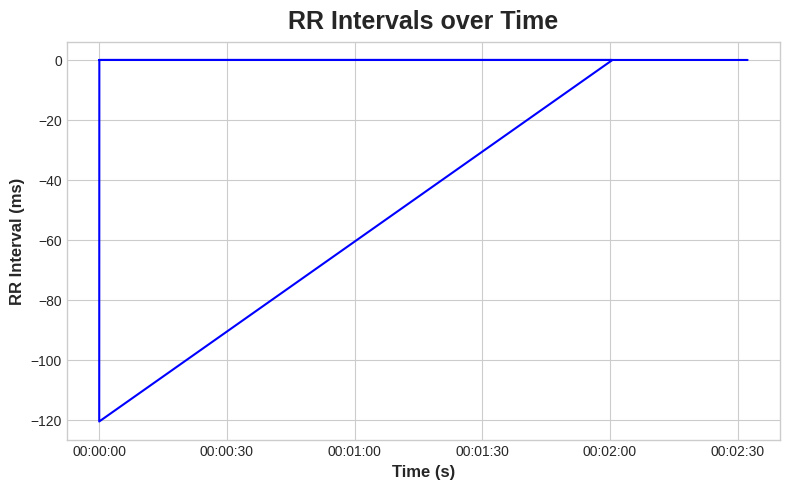

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df['Time'], df['RR Interval'], 'b')
plt.xlabel('Time (s)')
plt.ylabel('RR Interval (ms)')
plt.title('RR Intervals over Time')
plt.show()


**Power Spectral Density plot**
which shows the distribution of power within diffrent frequency band

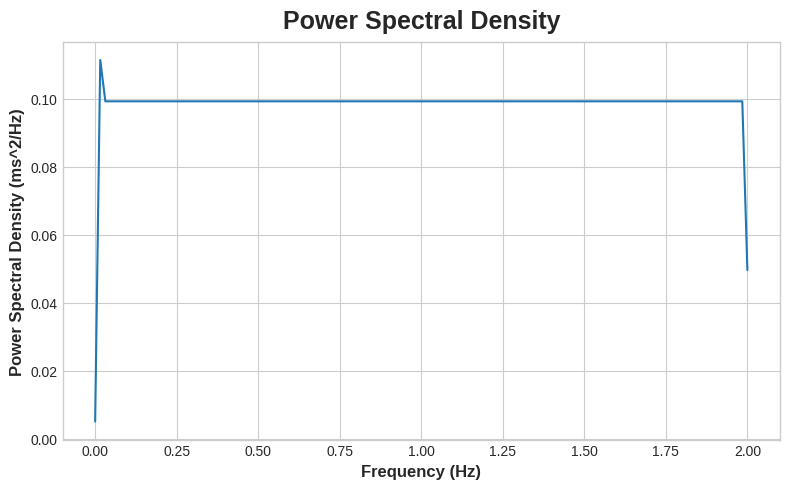

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (ms^2/Hz)')
plt.title('Power Spectral Density')
plt.show()


In [ ]:
df['RR Interval Shift'] = df['RR Interval'].diff()

**Scatter plot of any pair of variables**

In [ ]:
df.columns

Index(['Time', 'Pulse', 'Heart Rate', 'HRV Low Power', 'HRV High Power',
       'HRV Ratio', 'RR Interval', 'RR Interval Shift'],
      dtype='object')

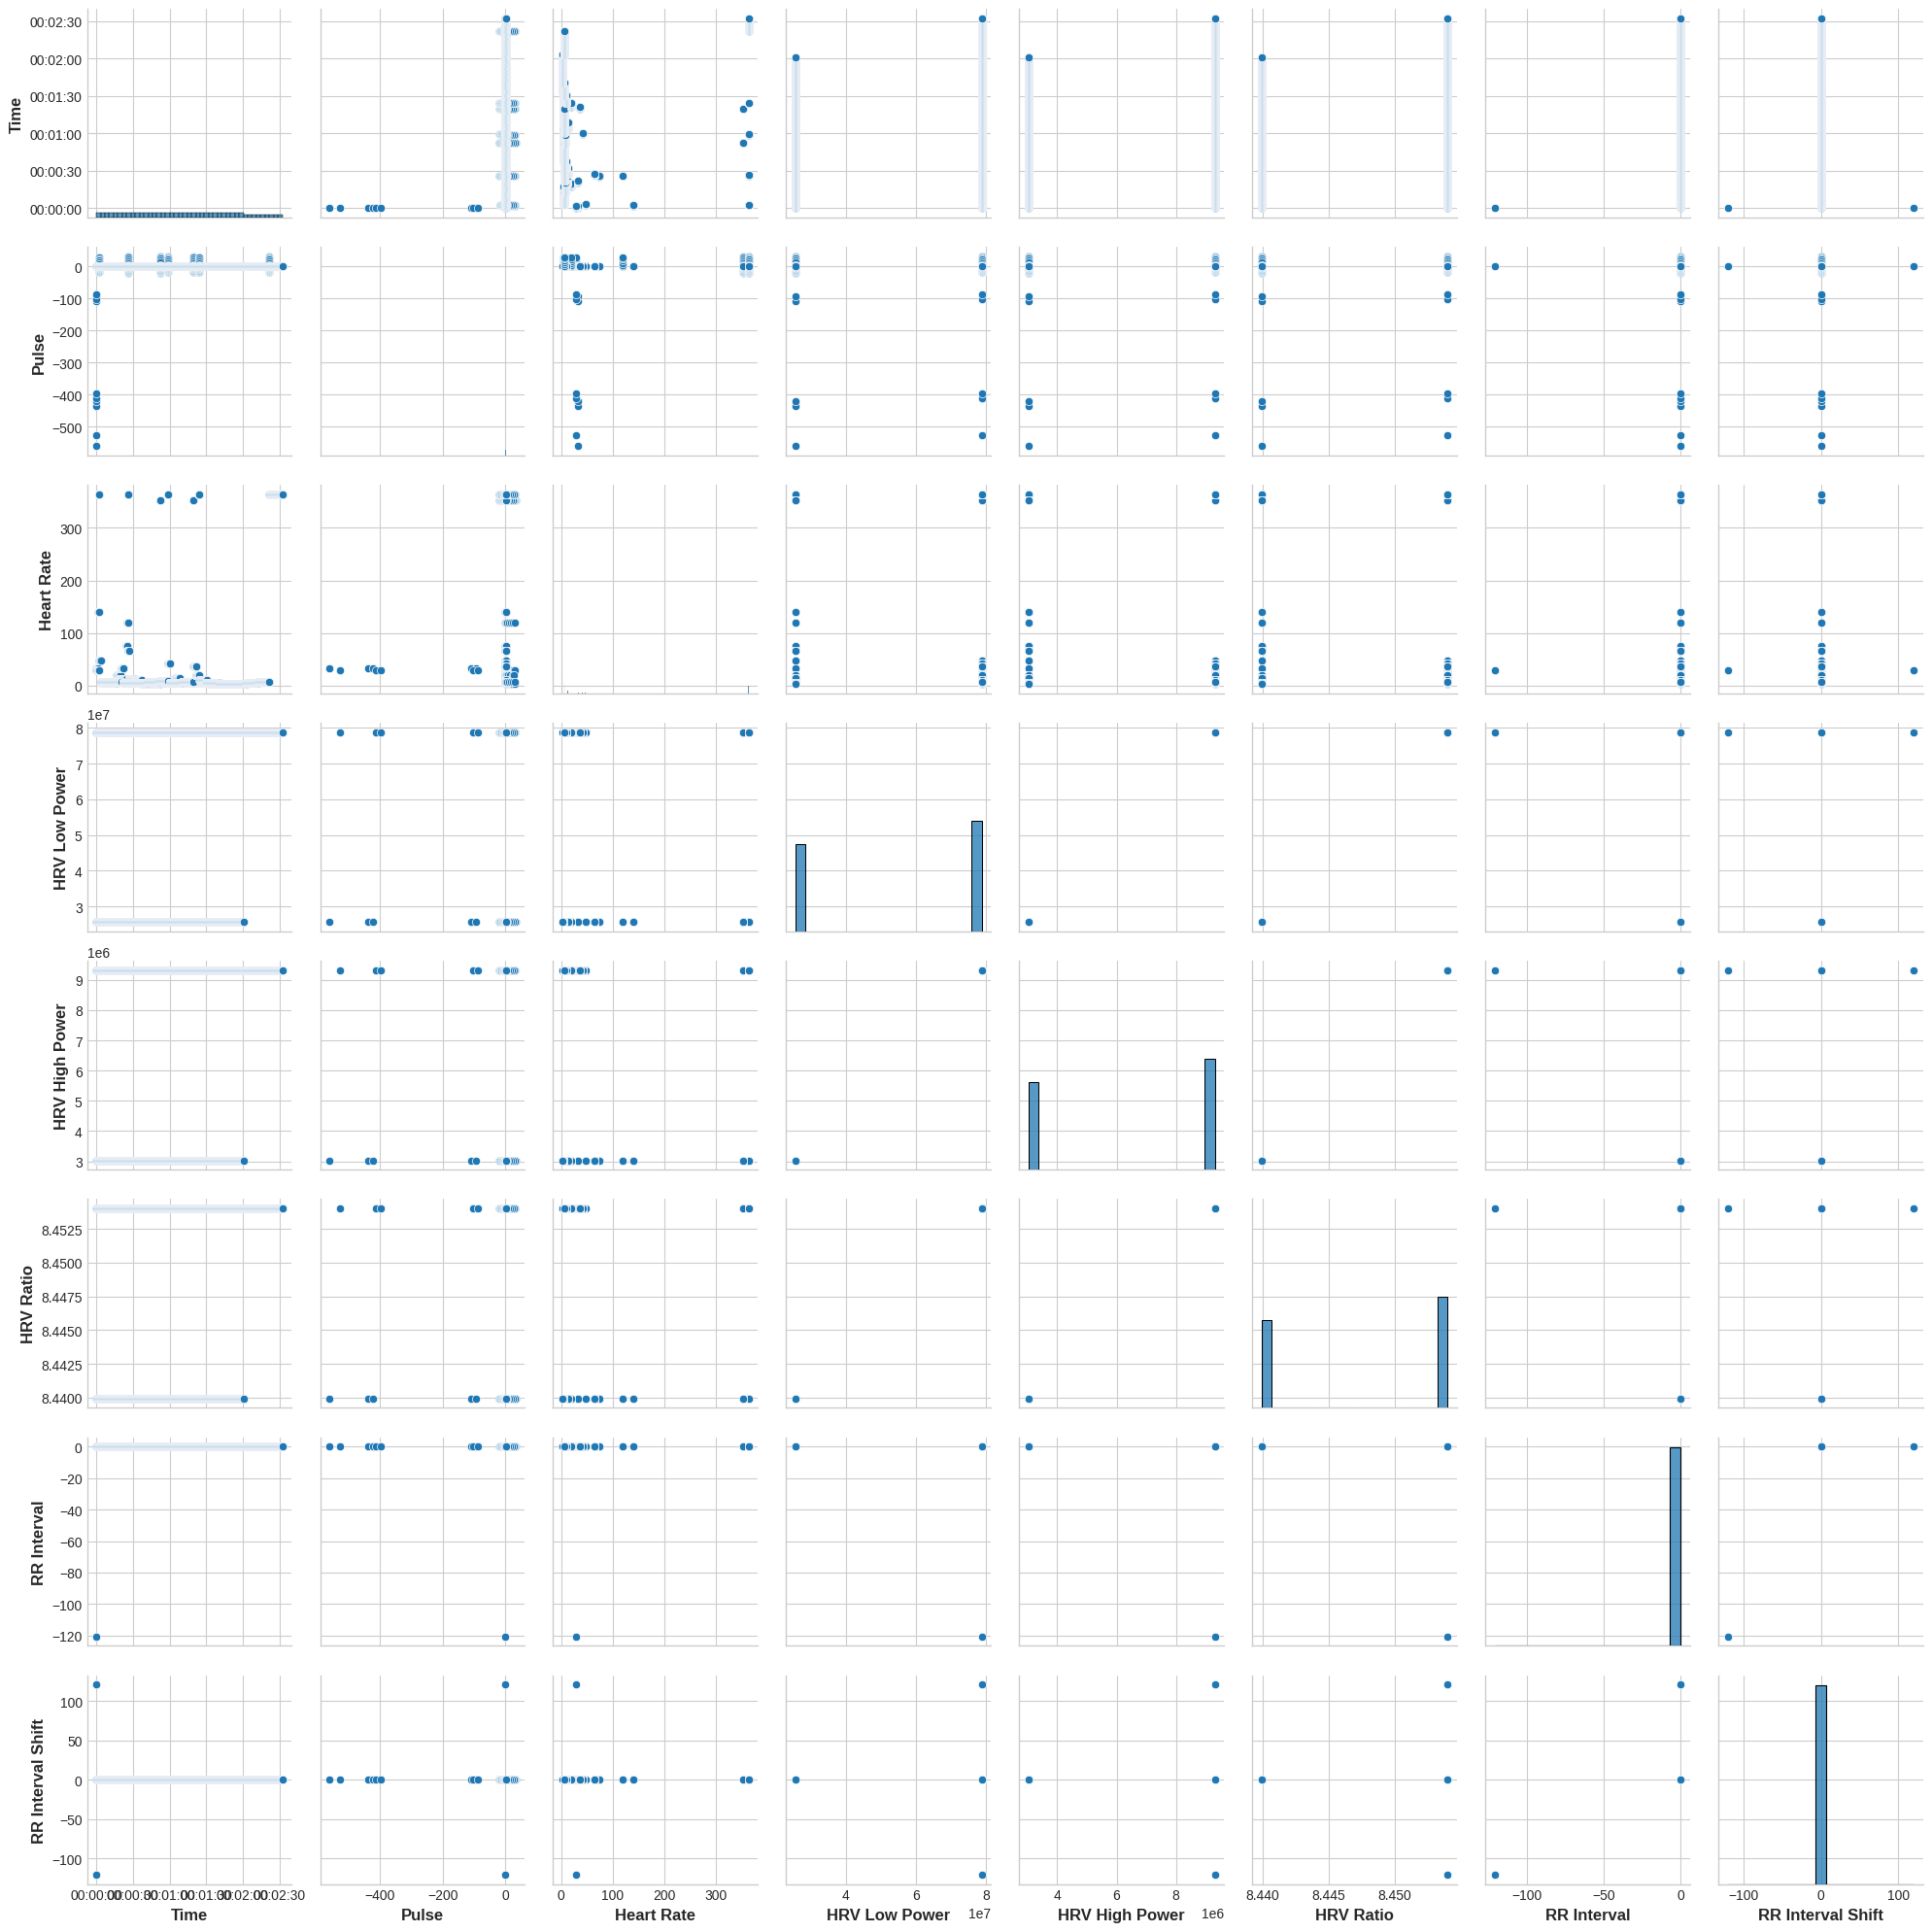

In [ ]:
sns.pairplot(data=df, vars=[column for column in df.columns])
plt.show()

Not suprised about these results as most of the variables have similar values and there's highly low variablity within a variable (a variable have almost the same values)

**Finally, Let me make line plots for Time against all other variables in the original dataset.This plot can be used to visualize the changes in a particular HRV parameter over time that shows the changes in variables over time during the baseline and after-activity periods.**

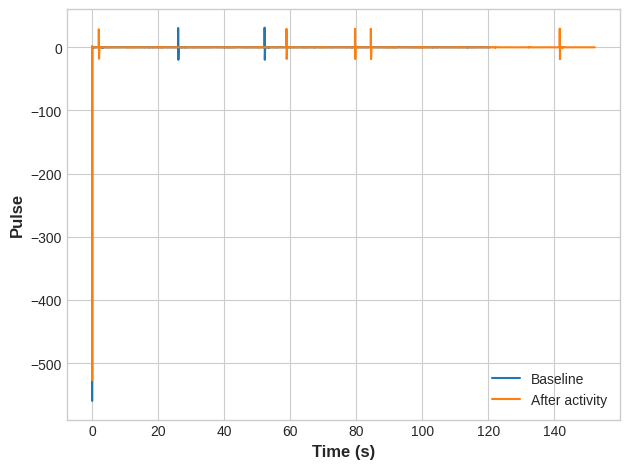

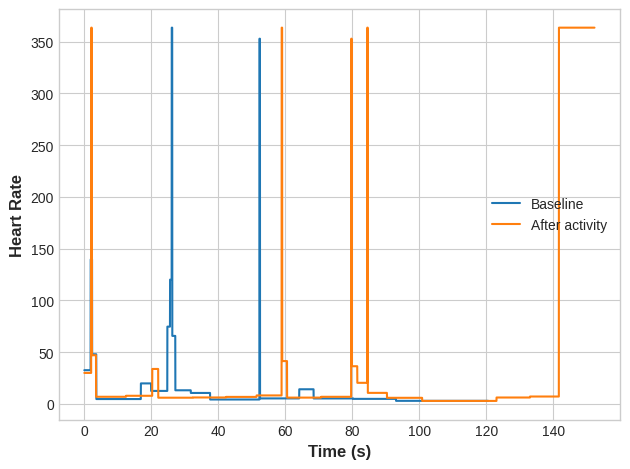

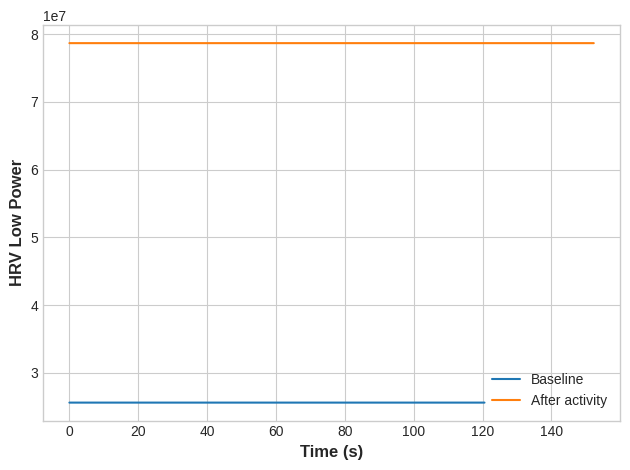

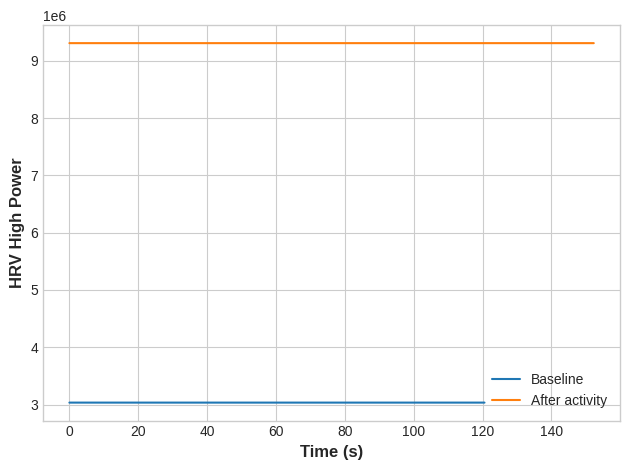

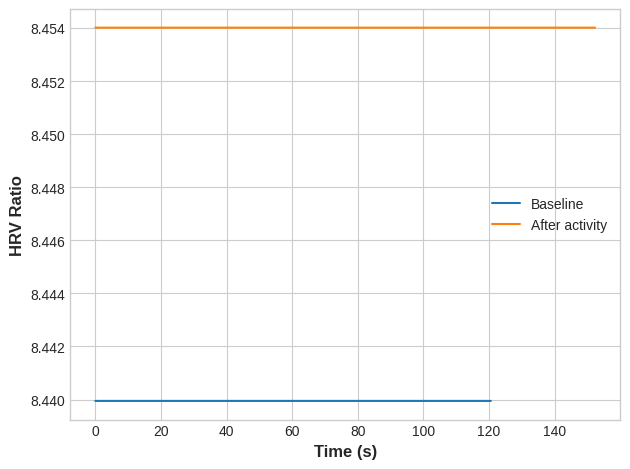

In [ ]:
# Line plot
for col in df_baseline.columns[1:]:
  plt.plot(df_baseline['Time'], df_baseline[col], label='Baseline')
  plt.plot(df_after['Time'], df_after[col], label='After activity')
  plt.xlabel('Time (s)')
  plt.ylabel(col)
  plt.legend()
  plt.show()

In [ ]:
# Save the final data as a csv file.
df.to_csv('HRV_final_data.csv', index=False)

# **END**